### 観測データ
解析に必要なデータ
- XFFTS data
- Encoder data
- weather status
- hosei copy
- obs copy

中間生成データ
- encoder npy
- xffts npy
- vobs npy

### 解析フロー

- doppler tracking[o]
     - XFFTSのtimestampとRa, Decの情報からvobsを計算します。
     - vobsの量だけchをずらします。(小数chのずれは線形補完で計算してずらします)
- Chopper Wheel [o]
- baseline fitting [o]
- Scaling(from standard object?) [x]
- regrid [o]
    - rms [o]
    - distance [o]
- +header [o]
- 3d-fits[o]

In [13]:
import sys
sys.path.append("../script/")
import time
import subprocess
import os
import numpy
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
import numba
from astropy.io import fits
from scipy import interpolate
###以下独自
import n2df
import read_obsfile
import analy_doppler_nanten
import log_weather

In [14]:
analy_dir = "/home/amigos/data/otf_2019/n20190904142646_12CO_2-1_otf_OriKL"#新形式
subprocess.getoutput(["ls {}".format(analy_dir)]).split("\n")

['enc.db',
 'encoder_radec.npy',
 'hosei_230.txt',
 'line_otf_OriKL_dcosy.obs',
 'test20190905.fits',
 'test20190906.fits',
 'test20190906_v2.fits',
 'test20190906_v3.fits',
 'test20190906_v.fits',
 'test4.fits',
 'vobs.npy',
 'weather.csv',
 'xffts.ndf',
 'xffts_radec.npy']

In [15]:
###気象情報の読み込み
weather_data = log_weather.Weather_log(os.path.join(analy_dir, "weather.csv")).read()
print(weather_data)
#気象データの確認
humi = numpy.mean(weather_data["outhumi"])
press = numpy.mean(weather_data["press"])
temprature = numpy.mean(weather_data["outtemp"])
lamda = 1300
cabin_temp = weather_data["cabin_temp1"]

      timestamp     intemp    outtemp    inhumi   outhumi     winddir  \
0  1.567607e+09  15.165850  16.762726  1.233124  8.473565  268.908455   
1  1.567607e+09  14.549850  16.380080  1.769449  8.764045  268.062679   
2  1.567607e+09  14.352203  16.540349  1.371281  8.939968  268.232077   
3  1.567607e+09  14.832550  16.516944  1.410851  8.499712  268.703383   
4  1.567607e+09  15.014435  16.310218  1.383554  8.001146  268.403536   
5  1.567607e+09  15.227496  16.502959  1.787469  8.020369  268.405620   
6  1.567607e+09  14.941033  16.210031  1.054588  8.859497  268.497477   
7  1.567607e+09  15.312008  16.305998  1.351483  8.623849  268.810436   
8  1.567607e+09  14.806064  16.560436  1.701079  8.045723  268.784821   

     windsp       press      rain  cabin_temp1  cabin_temp2  dome_temp1  \
0  6.788000  570.449484  0.367690    21.823577    31.744922    9.926390   
1  6.283264  570.372420  0.431126    22.097574    32.098455   10.393100   
2  5.868241  570.252858  0.744092    21.7187

In [73]:
%%time
if not os.path.exists(os.path.join(analy_dir, "xffts_radec.npy")):
    cmd = "python /home/amigos/git/analy_n2data/script/analy_coordinates.py {analy_dir} -p {press} -l {lamda} -hu  {humi} -t {temprature}".format(**locals())
    subprocess.run(cmd.split())

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 352 µs


In [74]:
###AzEl情報をradecに変換したものの一時ファイルの読み込み
path_xffts_c = os.path.join(analy_dir, "xffts_radec.npy")
path_encoder_c = os.path.join(analy_dir, "encoder_radec.npy")
xffts = numpy.load(path_xffts_c)
encoder = numpy.load(path_encoder_c)

### gridの作成


In [20]:
#観測プログラムから必要な情報を出す
obsfile_dict = read_obsfile.read(os.path.join(analy_dir, "line_otf_OriKL_dcosy.obs"))
lamda_on = obsfile_dict["lambda_on"]
beta_on = obsfile_dict["beta_on"]
N = obsfile_dict["N"]
grid = obsfile_dict["grid"]/3600 #[deg]

In [21]:
obsfile_dict

{'N': 9,
 'acc': 10,
 'beta_off': -5.6683,
 'beta_on': -5.37432,
 'betdel_off': 0,
 'cold_flag': 'N',
 'coordsys': 'j2000',
 'cosydel': 'j2000',
 'datanum': 9.0,
 'end_ch_1': 16383,
 'end_ch_2': 16383,
 'exposure': 0.6,
 'exposure_off': 10.0,
 'fpga_integtime': 100,
 'grid': 30,
 'if1st_freq_1': 4438.0,
 'if1st_freq_2': 5701.3,
 'if3rd_freq_1': 500.0,
 'if3rd_freq_2': 500.0,
 'lambda_off': 82.559,
 'lambda_on': 83.80613,
 'lamdel_off': 0,
 'lamp_pixels': 4,
 'lo1st_sb_1': 'U',
 'lo1st_sb_2': 'L',
 'lo2nd_sb_1': 'L',
 'lo2nd_sb_2': 'L',
 'lo3rd_freq_1': 4100.0,
 'lo3rd_freq_2': 4100.0,
 'lo3rd_sb_1': 'L',
 'lo3rd_sb_2': 'L',
 'load_interval': 5,
 'molecule_1': '12CO',
 'molecule_2': '13CO',
 'multiple': 12,
 'nTest': 1,
 'object': 'OriKL',
 'observer': 'amigos',
 'obsfreq_1': 230538.0,
 'obsfreq_2': 220398.684,
 'obsmode': 'LINEOTF',
 'offset_Az': 0,
 'offset_El': 0,
 'otadel': 'N',
 'otadel_off': 'N',
 'otflen': 5.4,
 'otfvel': 50.0,
 'pllharmonic': 1,
 'pllref_if': 1,
 'pllreffreq': 0

In [65]:
#今回girdからどこまで離れた範囲まで解析の中に含めるかの値。これは外からいじれる値にしておかないと
offset = 80#半径[arcsec]
array_num = 2#1~16IF 

In [66]:
#make gird
ragrid = numpy.linspace(lamda_on - ((N-1)/2)*grid, lamda_on + ((N-1)/2)*grid, num=9)
decgrid = numpy.linspace(beta_on - ((N-1)/2)*grid, beta_on + ((N-1)/2)*grid, num=9)
radec_grid = numpy.meshgrid(ragrid, decgrid)
numpy.shape(radec_grid)

(2, 9, 9)

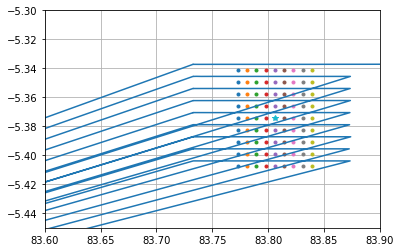

In [67]:
#gridの確認
#girdとXFFTSの点がずれている。
plt.plot(radec_grid[0], radec_grid[1], ".")
plt.plot(lamda_on, beta_on, "*")
plt.plot(xffts[0], xffts[1])
#plt.plot(encoder[0], encoder[1], ".")
plt.xlim(83.6, 83.9)
plt.ylim(-5.45, -5.3)
plt.savefig("neko.pdf")
plt.grid()
plt.show()

### なんで線と点がずれているんだ？

In [69]:
%%time
#分光データの読み出し
n = n2df.Read(os.path.join(analy_dir, "xffts.ndf"))
array_data = n.read_onearray(array_num)#1IFの分光データ
obs_mode = n.read_obs_mode()#観測モード（ON/OFF/HOT）
scan_num = n.read_scan_num()#スキャンライン（0,1,2,3,4,...）
###array_data, scan_num, obs_mode = n.read_for_otf(1)#3分くらいかかた




  0%|          | 0/2146 [00:00<?, ?it/s]


 34%|███▍      | 738/2146 [00:00<00:01, 1239.50it/s]


 63%|██████▎   | 1351/2146 [00:00<00:00, 1629.46it/s]


100%|██████████| 2146/2146 [00:00<00:00, 2755.78it/s]


  0%|          | 0/2146 [00:00<?, ?it/s]


100%|██████████| 2146/2146 [00:00<00:00, 179152.43it/s]


  0%|          | 0/2146 [00:00<?, ?it/s]


100%|██████████| 2146/2146 [00:00<00:00, 507325.92it/s]

CPU times: user 84 ms, sys: 128 ms, total: 212 ms
Wall time: 873 ms


## doppler tracking


In [70]:
if not os.path.exists(os.path.join(analy_dir, "vobs.npy")):
    from numpy import deg2rad
    d = analy_doppler_nanten.doppler_nanten()
    vobs = [d.calc_vobs(deg2rad(xffts[0][i]),deg2rad(xffts[1][i]), xffts[2][i]) for i in tqdm(range(len(xffts[0])))]
    # joblib version
    #vobs = Parallel(n_jobs=-1, verbose=2)([delayed(d.calc_vobs(deg2rad(xffts[0][i]), deg2rad(xffts[1][i]), xffts[2][i])) for i in tqdm(range(len(xffts[0])))])
else:
    print(" vobs.npy already exists")

 vobs.npy already exists


In [71]:
numpy.save(os.path.join(analy_dir, "vobs"), vobs)

In [83]:
vobs = numpy.load(os.path.join(analy_dir, "./vobs.npy"))

# For debug
if numpy.count_nonzero(vobs>0) == len(vobs):
    print("vobsは全て正")
elif numpy.count_nonzero(vobs<0) == len(vobs):
    print("vobsは全て負")
else:
    print("vobsは正も負もある")

# config
dv = 0.167#km/s
ch = numpy.linspace(0, 32767, 32768)
bch = list(map(int, vobs//dv))#ch数の移動
slide_ch = (vobs/dv) - bch#interpolationによる移動量

dp_data = []
xx_data = []
for i in tqdm(range(len(vobs))):
    f = interpolate.interp1d(ch, array_data[i])
    ch2 = ch+slide_ch[i]
    if slide_ch[i] > 0:
        n = f(ch2[:-1])
    elif slide_ch[i] <0:
        n = f(ch2[1:])
    new_p = n
    xx = ch[:-1] - bch[i]
    yy = new_p
    xx_data.append(xx)
    dp_data.append(yy)




  0%|          | 0/2146 [00:00<?, ?it/s]


  1%|▏         | 27/2146 [00:00<00:07, 266.09it/s]

vobsは全て正





  3%|▎         | 60/2146 [00:00<00:07, 280.60it/s]


  4%|▍         | 90/2146 [00:00<00:07, 283.70it/s]


  6%|▌         | 129/2146 [00:00<00:06, 306.85it/s]


  8%|▊         | 161/2146 [00:00<00:06, 309.91it/s]


  9%|▉         | 188/2146 [00:00<00:07, 277.98it/s]


 10%|▉         | 214/2146 [00:00<00:07, 261.98it/s]


 11%|█         | 241/2146 [00:00<00:07, 264.23it/s]


 12%|█▏        | 267/2146 [00:00<00:07, 252.02it/s]


 14%|█▎        | 292/2146 [00:01<00:07, 245.62it/s]


 15%|█▌        | 322/2146 [00:01<00:07, 259.60it/s]


 17%|█▋        | 359/2146 [00:01<00:06, 282.25it/s]


 18%|█▊        | 393/2146 [00:01<00:05, 295.63it/s]


 20%|█▉        | 424/2146 [00:01<00:05, 288.31it/s]


 21%|██        | 454/2146 [00:01<00:06, 271.19it/s]


 22%|██▏       | 482/2146 [00:01<00:06, 249.02it/s]


 24%|██▎       | 508/2146 [00:01<00:06, 251.46it/s]


 25%|██▍       | 534/2146 [00:01<00:06, 252.69it/s]


 26%|██▌       | 563/2146 [00:02<00:06, 260.63it/s]


 27%|██▋       | 590/2146 [

In [106]:
xx_data = numpy.array(xx_data)
xx_min = numpy.max(xx_data.T[0])#regridの最小値
xx_max = numpy.min(xx_data.T[-1])#regirdの最大値

new_xx = numpy.arange(xx_min, xx_max+1, 1)
print(new_xx, len(new_xx))
vlen = len(new_xx)

[-1242. -1241. -1240. ... 31521. 31522. 31523.] 32766


In [107]:
mask_list= []
for i in range(len(xx_data)):
    mask = (xx_data[i] >= xx_min) & (xx_data[i] <= xx_max)
    mask_list.append(mask)

In [108]:
new_yy_list = []
for i in tqdm(range(len(xx_data))):
    new_yy_list.append(dp_data[i][mask_list[i]])




  0%|          | 0/2146 [00:00<?, ?it/s]


 33%|███▎      | 705/2146 [00:00<00:00, 7043.94it/s]


 62%|██████▏   | 1328/2146 [00:00<00:00, 6777.09it/s]


 89%|████████▉ | 1916/2146 [00:00<00:00, 6479.43it/s]


100%|██████████| 2146/2146 [00:00<00:00, 6140.35it/s]

In [109]:
len(new_xx)
origin_array_data = array_data
array_data = new_yy_list
numpy.shape(array_data)

(2146, 32766)

(7100, 7200)

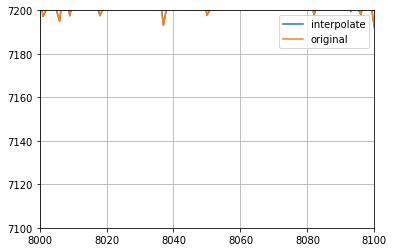

In [110]:
%matplotlib inline
plt.plot(new_yy_list[0], label="interpolate")
plt.plot(origin_array_data[0], label="original")
plt.legend()
plt.grid()
#plt.xlim(7500,8300)
plt.xlim(8000,8100)
plt.ylim(7100, 7200)


on/off/hot indexの整理

In [111]:
###index探し
obs_mode = numpy.array(obs_mode)
scan_num = numpy.array(scan_num)

offmask = obs_mode == "OFF"
offindex = numpy.where(offmask == True)

hotmask = obs_mode == "HOT"
hotindex = numpy.where(hotmask == True)

onmask = obs_mode == "ON"
onindex = numpy.where(onmask == True)

max_scannum = numpy.max(scan_num)#Caution! scan num starts from 0, so scan number of 26 indicates 27 times scan

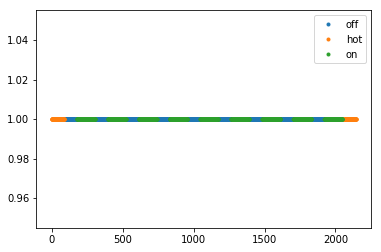

In [112]:
#一応indexの可視化
plt.plot(offindex[0], [1]*len(offindex[0]),"." , label = "off")
plt.plot(hotindex[0], [1]*len(hotindex[0]),"." , label = "hot")
plt.plot(onindex[0], [1]*len(onindex[0]),"." , label = "on")
# plt.xlim(0,1000)
plt.legend()
plt.show()

[0 0 0 ... 9 9 9]


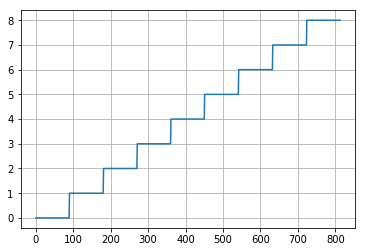

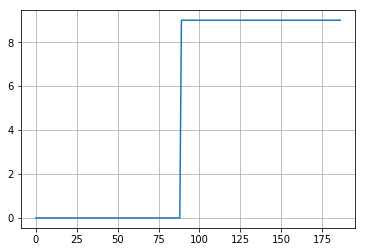

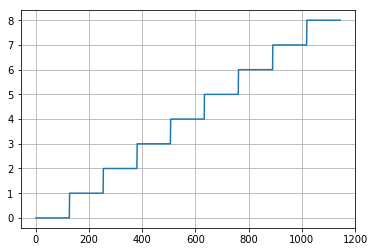

In [113]:
#OFF 点のscan number を取得
scan_num = numpy.array(scan_num)
print(scan_num)
offindex[0]
plt.plot(scan_num[offindex[0]])
plt.grid()
plt.show()

#HOT 点のscan number を取得
scan_num = numpy.array(scan_num)
hotindex[0]
plt.plot(scan_num[hotindex[0]])
plt.grid()
plt.show()

# ON 点のscan number を取得
scan_num = numpy.array(scan_num)
plt.plot(scan_num[onindex[0]])
plt.grid()
plt.show()

### hot/offの積分

In [114]:
len(array_data)

2146

In [115]:
#HOT積分
print(numpy.unique(scan_num[hotindex[0]]))#HOT のscan number
hotnum = numpy.unique(scan_num[hotindex[0]])#HOTの数

hotdata = []

for i in tqdm(hotnum):#i = scan number
    mask = scan_num == i#特定のscannumのindexを抜き出す
    index = numpy.where(mask == True)#特定のscannumのindex変数
   ### 
    c = numpy.in1d(index[0], hotindex[0])#特定のscannumのindex&HOT index
    c = numpy.where(c == True)[0]
    ###
    mm = index[0][c]#scan numの値でフィルターしたhot
    print(mm)
    ###積分
    tmp = [array_data[j] for j in mm]
    hotdata.append(sum(tmp)/len(tmp))
    pass

#下は擬似データの質が低いための処理。将来的に削除
hotdata = numpy.array(hotdata)
hotdata = hotdata + 5000




  0%|          | 0/2 [00:00<?, ?it/s]


100%|██████████| 2/2 [00:00<00:00, 235.13it/s]

[0 9]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88]
[2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061
 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075
 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089
 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 2101 2102 2103
 2104 2105 2106 2107 2108 2109 2110 2111 2112 2113 2114 2115 2116 2117
 2118 2119 2120 2121 2122 2123 2124 2125 2126 2127 2128 2129 2130 2131
 2132 2133 2134 2135 2136 2137 2138 2139 2140 2141 2142 2143 2144 2145]


In [116]:
##OFFの積分
print(numpy.unique(scan_num[offindex[0]]))#HOT のscan number
offnum = numpy.unique(scan_num[offindex[0]])#HOTの数

offdata = []
scan_num = numpy.array(scan_num)

for i in tqdm(offnum):
    mask = scan_num == i#特定のscannumのindexを抜き出す
    index = numpy.where(mask == True)#特定のscannumのindex変数
   ### 
    c = numpy.in1d(index[0], offindex[0])#特定のscannumのindex&HOT index
    c = numpy.where(c == True)[0]#scannumとhotで絞ったindex
    mm = index[0][c]#scan numの値でフィルターしたhot
    tmp = [array_data[j] for j in mm]
    offdata.append(sum(tmp)/len(tmp))




  0%|          | 0/9 [00:00<?, ?it/s]


100%|██████████| 9/9 [00:00<00:00, 272.87it/s]

[0 1 2 3 4 5 6 7 8]


Hot のデータはscan line分あるわけでないので補完
Off もscan line 分ある観測プログラムしかないはずだが、一応補完

補完の方法は次のOFF/HOTの点の観測を行うまでは直近のデータを採用する形

In [117]:
d = numpy.unique(scan_num[hotindex[0]])#HOT のscan number
hotdata_ = []
count = 0

for i in tqdm(range(max_scannum)):
        #print(i,count)
        if i == d[count]:
            hotdata_.append(d[count])
            count +=1
        elif i < d[count]:
            hotdata_.append(d[count])
        else:#この例外には入らないはず
            print(i)




  0%|          | 0/9 [00:00<?, ?it/s]


100%|██████████| 9/9 [00:00<00:00, 6330.49it/s]

In [118]:
d = numpy.unique(scan_num[offindex[0]])#HOT のscan number
offdata_ = []
count = 0

for i in tqdm(range(max_scannum)):
        #print(i,count)
        if i == d[count]:
            offdata_.append(d[count])
            count +=1
        elif i < d[count]:
            offdata_.append(d[count])
        else:#この例外には入らないはず
            print(i)




  0%|          | 0/9 [00:00<?, ?it/s]


100%|██████████| 9/9 [00:00<00:00, 8548.17it/s]

In [119]:
# ###Choper wheel

@numba.jit
def chopper_wheel(on_index, scan_num, temprature = 300):    
    #scan_num = n[on_index]["scan_num"]
    #Tastar = (array_data[on_index] - offdata[scan_num])/(hotdata[scan_num] - offdata[scan_num]) * temprature
    Tastar = (array_data[on_index] - offdata[0])/(hotdata[0] - offdata[0]) * temprature#test, this will be deleted（hotdata, offdata[0]しかつかってない！）
    return Tastar

def calc(i):#on点をscan indexでmaskしchopper wheelする
    mask = scan_num == i#特定のscannumのindexを抜き出す
    index = numpy.where(mask == True)#特定のscannumのindex変数
    c = numpy.intersect1d(index[0], onindex[0])
    return [[j, chopper_wheel(j, i, cabin_temp[i])] for j in c]###j= index 

In [120]:
ondata = [calc(i) for i in tqdm(range(max_scannum+1))]#Chopper Wheelしたやつ




  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [00:02<00:21,  2.36s/it]


 50%|█████     | 5/10 [00:02<00:08,  1.66s/it]


 90%|█████████ | 9/10 [00:02<00:01,  1.18s/it]


100%|██████████| 10/10 [00:02<00:00,  3.79it/s]

In [121]:
%%time
data_on = {ondata[i][j][0]:ondata[i][j][1] for i in range(len(ondata)) for j in range(len(ondata[i]))}###d[onindex] = onarray

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.03 ms


In [122]:
#距離による重みつけ関数１
#sigma == ビームサイズ
def gauss(x, a = 1, mu = 0, sigma = 160):
    return a * numpy.exp(-(x - mu)**2 / (2*sigma**2))


#距離による重みつけ関数2 関数系わからないので今はgaussianだけど修正
def bessel_gauss(x, a = 1, mu = 0, sigma = 160):
    return a * numpy.exp(-(x - mu)**2 / (2*sigma**2))

#球面なのでRA方向の長さがDECで変わります。なのでRA-DEC平面での距離(角度)を出すには、RAをcos(DEC)で割る必要があります。
def calc_distance(d1, d2):
    #d1 = [ra, dec] #deg   
    factor = 3600#こういうことしなくてもいいようにastropy unitを使う（要編集）
    d1[0] = d1[0]*factor
    d1[1] = d1[1]*factor
    d2[0] = d2[0]*factor
    d2[1] = d2[1]*factor
    return ((d1[0] - d2[0])**2 + (d1[1] - d2[1])**2)**0.5

def calc_rms(arr):
    return numpy.sqrt(numpy.mean(arr**2))

def rms_dist_weighting(arr, dist, rms):
    return [arr*gauss(dist)*(rms**-2), gauss(dist)*(rms**-2)]

## Baseline fitting




  0%|          | 0/1145 [00:00<?, ?it/s]

3000 7500 8500 30000





  2%|▏         | 24/1145 [00:00<00:04, 232.07it/s]


  4%|▍         | 50/1145 [00:00<00:04, 237.85it/s]


  7%|▋         | 77/1145 [00:00<00:04, 244.96it/s]


  9%|▉         | 105/1145 [00:00<00:04, 253.42it/s]


 12%|█▏        | 134/1145 [00:00<00:03, 261.13it/s]


 14%|█▍        | 163/1145 [00:00<00:03, 267.17it/s]


 17%|█▋        | 191/1145 [00:00<00:03, 269.33it/s]


 19%|█▉        | 217/1145 [00:00<00:04, 225.65it/s]


 21%|██        | 240/1145 [00:00<00:04, 223.40it/s]


 23%|██▎       | 264/1145 [00:01<00:03, 225.64it/s]


 25%|██▌       | 289/1145 [00:01<00:03, 229.69it/s]


 28%|██▊       | 315/1145 [00:01<00:03, 236.29it/s]


 30%|██▉       | 343/1145 [00:01<00:03, 246.43it/s]


 32%|███▏      | 371/1145 [00:01<00:03, 254.68it/s]


 35%|███▌      | 401/1145 [00:01<00:02, 266.11it/s]


 38%|███▊      | 438/1145 [00:01<00:02, 290.47it/s]


 41%|████      | 472/1145 [00:01<00:02, 303.22it/s]


 44%|████▍     | 504/1145 [00:01<00:02, 279.09it/s]


 47%|████▋     | 533/1145 [0

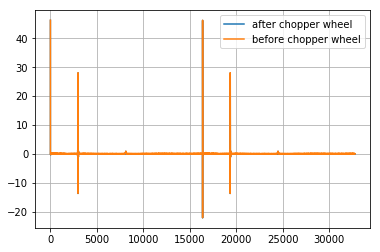

In [123]:
#baseline fitting parameter
center = 8000
width = 1000
start = 3000
end = 30000

#baseline fitting function
def f(x, a, b, c):
    return a*x**2 + b*x + c

def  baseline_fitting(arr_x, arr_y, index1, index2, index3, index4):
    tmpdata_y1 = arr_y[index1:index2]
    tmpdata_y2 = arr_y[index3:index4]
    tmpdata_x1 = arr_x[index1:index2]
    tmpdata_x2 = arr_x[index3:index4]
    x = numpy.concatenate([tmpdata_x1, tmpdata_x2])
    y = numpy.concatenate([tmpdata_y1, tmpdata_y2])
    param = numpy.polyfit(x, y, 2)
    arr_y = arr_y - f(arr_x, *param)
    return arr_y
    
#ch
xindex = numpy.linspace(0, vlen, vlen)###要注意 32768==>32766 一時的

#baseline fitting index
index1 = int(start)
index2 = int(center - width/2)
index3 = int(center + width/2)
index4 = int(end)
print(index1, index2, index3, index4)

testoffset = numpy.linspace(1, vlen, vlen)###要注意 32768==>32766 一時的

for i in tqdm(data_on.keys()):
    origin = data_on[i]#for debug, this will be deleted
    data_on[i] = data_on[i] + testoffset#ベースラインフィッティングできているかの確認のため
    data_on[i] = baseline_fitting(xindex, data_on[i], index1, index2, index3, index4)
    
    
plt.plot(data_on[i], label="after chopper wheel")#after chopper wheel
plt.plot(origin, label="before chopper wheel")#before chopper wheel
plt.legend()
plt.grid()

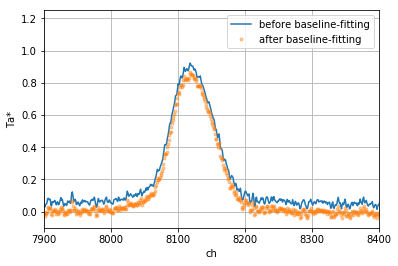

In [124]:
%matplotlib inline
plt.plot(origin, label="before baseline-fitting")#before chopper wheel
plt.plot(data_on[i], ".", label="after baseline-fitting", alpha=0.4)#after chopper wheel
plt.ylabel("Ta*")
plt.xlabel("ch")
plt.xlim(7900,8400)
plt.ylim(-0.1,1.25)
plt.legend()
plt.grid()

## grid内のデータ探索

あるgridに採用するデータのindexを求める

In [125]:
%time
index_list = []
for i in tqdm(range(max_scannum)):
    for j in range(max_scannum):
       # print(ragrid[i], decgrid[j])
        index1 = numpy.where((ragrid[i]-(offset/3600)<xffts[0]) & ((ragrid[i] + (offset/3600)>xffts[0])))
        index2 = numpy.where((decgrid[j]-(offset/3600)<xffts[1]) & ((decgrid[j] + (offset/3600)>xffts[1])))
        index_ = [i in index2[0] for i in index1[0]]
        index_ = numpy.array(index_)
        index_1and2 = numpy.where(index_ == True)
        index_1and2 = index1[0][index_1and2]
        index_list.append(index_1and2)





  0%|          | 0/9 [00:00<?, ?it/s]


 44%|████▍     | 4/9 [00:00<00:00, 35.76it/s]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.44 µs





 89%|████████▉ | 8/9 [00:00<00:00, 35.22it/s]


100%|██████████| 9/9 [00:00<00:00, 35.09it/s]

### xfftsデータの確認

### データをgridに入れる

データの重見つけは以下
$$
    T = \frac{\sum_{n} T_n \frac{1}{\sigma_n^2}G(r_n)}{\sum_{n} \frac{1}{\sigma_n^2}G(r_n)}
$$

$$
    \sigma_n ：rms
    r_n :distance fo
$$


In [126]:
%%time
#cubeデータの作成
#data_c = numpy.zeros((31, 31, 32768))#(ra, dec, ch)
#index_list2 = numpy.reshape(index_list, (31,31))#index listの2次元化（これは前処理しておく） #これは正しいか？
data_c = numpy.zeros((max_scannum, max_scannum, vlen))#(ra, dec, ch)##要注意！！！
index_list2 = numpy.reshape(index_list, (max_scannum, max_scannum))#index listの2次元化（これは前処理しておく） #これは正しいか？

## Chopper wheelしたデータをdatacubeに入れる
for i in tqdm(range(max_scannum)):#ra
    for j in range(max_scannum):#dec
        try:
            numerator_list = []#分子
            denominator_list= []#分母
            for k in index_list2[i][j]:
                dist = calc_distance([ragrid[i], decgrid[j]], [xffts[0][k], xffts[1][k]])
                rms = calc_rms(data_on[k])
                weighted_data = rms_dist_weighting(data_on[k], dist, rms)
                #weighted_data = rms_dist_weighting(data_on[k], dist, 1)###RMSがうまく動いているかの確認
                numerator_list.append(weighted_data[0])
                denominator_list.append(weighted_data[1])
            data_c[i][j] = sum(numerator_list)/sum(denominator_list)
        except Exception as e:
            print("[{},{}], {}".format(i,j,e), end = "")




  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:00<00:03,  2.17it/s]


 22%|██▏       | 2/9 [00:00<00:03,  2.16it/s]


 33%|███▎      | 3/9 [00:01<00:02,  2.14it/s]


 44%|████▍     | 4/9 [00:01<00:02,  2.11it/s]


 56%|█████▌    | 5/9 [00:02<00:01,  2.18it/s]


 67%|██████▋   | 6/9 [00:02<00:01,  2.13it/s]


 78%|███████▊  | 7/9 [00:03<00:00,  2.19it/s]


 89%|████████▉ | 8/9 [00:03<00:00,  2.20it/s]


100%|██████████| 9/9 [00:04<00:00,  2.14it/s]

CPU times: user 2.37 s, sys: 1.1 s, total: 3.47 s
Wall time: 4.2 s


In [127]:
print(dist)
numerator_list[0]
denominator_list[4]

76.22589912720477


3.525318436882737

距離を考慮すると...

### astropyでfitsに書き出す

In [128]:
#3軸の入れ替え。
data_c = numpy.swapaxes(data_c, 0,2)
print(numpy.shape(data_c))#軸の入れ替えの確認

(32766, 9, 9)


ヘッダーの作成

In [129]:
vch = new_xx - 16384
crval3 = vch[0]*dv
print(new_xx)
print(crval3)

header_dict = {
"object": obsfile_dict["object"],
"crval1": obsfile_dict["lambda_on"],
"cdelt1": obsfile_dict["grid"]/3600,
"crpix1": obsfile_dict["N"]-1/2,#中心ピクセル
"crval2": obsfile_dict["beta_on"],
"cdelt2": obsfile_dict["grid"]/3600,
"crpix2": obsfile_dict["N"]-1/2, #中心ピクセル
"cdelt3": dv,# km/s 
"crval3": crval3
}

[-1242. -1241. -1240. ... 31521. 31522. 31523.]
-2943.5420000000004


In [130]:
# temp = """
# SIMPLE  =                    T                                                  
# BITPIX  =                  -32                                                  
# NAXIS   =                    3                                                  
# NAXIS1  =                  31                                                 
# NAXIS2  =                  31                                                 
# NAXIS3  =                   32768                                                  
# OBJECT  = '{object}              '                                                  
# TELESCOP= 'NANTEN2            '                                                  
# INSTRUME= 'nasco          '                                                  
# OBSERVER= 'amigos           '                                                  
# DATE-OBS= '2007-12-30        '                                                  
# DATE-MAP= '2012-01-19        '                                                  
# BSCALE  =    0.10000000000E+01                                                  
# BZERO   =    0.00000000000E+01                                                  
# BUNIT   = 'K                 '                                                  
# EPOCH   =    0.20000000000E+04                                                  
# OBSRA   =    8.38104170000E+01                                                  
# OBSDEC  =   -5.37511100000E+00                                                  
# DATAMAX =    1.16774444580E+02                                                  
# DATAMIN =   -8.33924560547E+01                                                  
# CTYPE1  = 'RA---GLS          '                                                  
# CRVAL1  =    {crval1}                                                  
# CDELT1  =    {cdelt1}                                                  
# CRPIX1  =      {crpix1}
# CROTA1  =     0.0000000000E+00                                                  
# CTYPE2  = 'DEC--GLS          '                                                  
# CRVAL2  =   {crval2}                                                  
# CDELT2  =   {cdelt2}                                               
# CRPIX2  =     {crpix2}                                               
# CROTA2  =     0.0000000000E+00                                                  
# CTYPE3  = 'VELO-LSR          '                                                  
# CRVAL3  =    {crval3}                                                  
# CDELT3  =    {cdelt3}                                                  
# CRPIX3  =    1.00000000000E+00                                                  
# CROTA3  =    0.00000000000E+00                                                  
# BLANK   =   -1.00000000000E+00 """.format(**header_dict)

In [131]:
temp = """
SIMPLE  =                    T                                                  
BITPIX  =                  -32                                                  
NAXIS   =                    3                                                  
NAXIS1  =                  31                                                 
NAXIS2  =                  31                                                 
NAXIS3  =                   32768                                                  
OBJECT  = '{object}              '                                                  
TELESCOP= 'NANTEN2            '                                                  
INSTRUME= 'nasco          '                                                  
OBSERVER= 'amigos           '                                                  
DATE-OBS= '2007-12-30        '                                                  
DATE-MAP= '2012-01-19        '                                                  
BSCALE  =    0.10000000000E+01                                                  
BZERO   =    0.00000000000E+01                                                  
BUNIT   = 'K                 '                                                  
EPOCH   =    0.20000000000E+04                                                  
OBSRA   =    8.38104170000E+01                                                  
OBSDEC  =   -5.37511100000E+00                                                  
DATAMAX =    1.16774444580E+02                                                  
DATAMIN =   -8.33924560547E+01                                                  
CTYPE1  = 'RA---GLS          '                                                  
CRVAL1  =    {crval1}                                                  
CDELT1  =    {cdelt1}                                                  
CRPIX1  =      {crpix1}
CROTA1  =     0.0000000000E+00                                                  
CTYPE2  = 'DEC--GLS          '                                                  
CRVAL2  =   {crval2}                                                  
CDELT2  =   {cdelt2}                                               
CRPIX2  =     {crpix2}                                               
CROTA2  =     0.0000000000E+00                                                  
CTYPE3  = 'km/s          '                                                  
CRVAL3  =    {crval3}                                                  
CDELT3  =    {cdelt3}                                                  
CRPIX3  =    1.00000000000E+00                                                  
CROTA3  =    0.00000000000E+00                                                  
BLANK   =   -1.00000000000E+00 """.format(**header_dict)

In [132]:
target_header = fits.Header.fromstring(temp, sep = "\n")

In [133]:
#書き出し
hdu = fits.PrimaryHDU(data_c, target_header)
hdulist = fits.HDUList([hdu])
hdulist.writeto(os.path.join(analy_dir, "test20190906_v3.fits"), overwrite = True)

In [134]:
##読み込み
hdu_list = fits.open(os.path.join(analy_dir, "test20190906_v3.fits"))
hdu_r = hdu_list[0]
data = hdu_r.data
header = hdu_r.header

### OTF MAP

In [136]:
#%matplotlib notebook
%matplotlib inline
from ipywidgets import interact

def plot(i):
    plt.figure(figsize=(8, 8))
    plt.imshow(data[i].T, cmap = "gist_rainbow")
    #plt.xlabel("ra")
    #plt.ylabel("dec")
    plt.show()


interact(plot, i = (0,16000,1))

A Jupyter Widget

<function __main__.plot>

### RMS Map

In [137]:
#rms map
data_rms = numpy.swapaxes(data, 0,2)

In [138]:
numpy.mean(data_rms[0][0]**2)

0.27933246757678937

In [139]:
rms_map = numpy.zeros((9,9))
for i in range(9):
    for j in range(9):
        rms_map[i][j] = numpy.sqrt(numpy.mean(data_rms[i][j]**2))

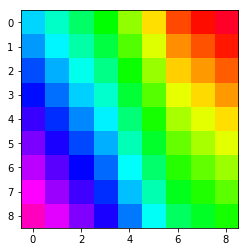

In [140]:
plt.imshow(rms_map, cmap = "gist_rainbow")

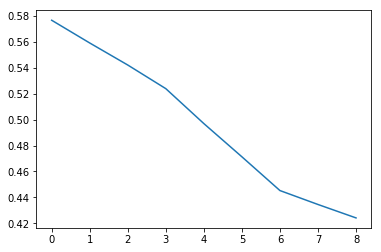

In [141]:
plt.plot(rms_map[4])

In [142]:
len(index_list2[0][8])

126

In [143]:
#bokeh  使い方あんまかしわからん
from bokeh.plotting import figure
from bokeh.io import show, output_notebook

output_notebook()
plt1 = figure()
rend1 = plt1.image(image=[data[16000]], x=0, y=0, dw =31, dh=31, palette="Plasma11")

show(plt1)

Loading BokehJS ...

In [144]:
numpy.max(data)

59.95489046472802

In [145]:
numpy.where(data > 213)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

<IPython.core.display.Javascript object>


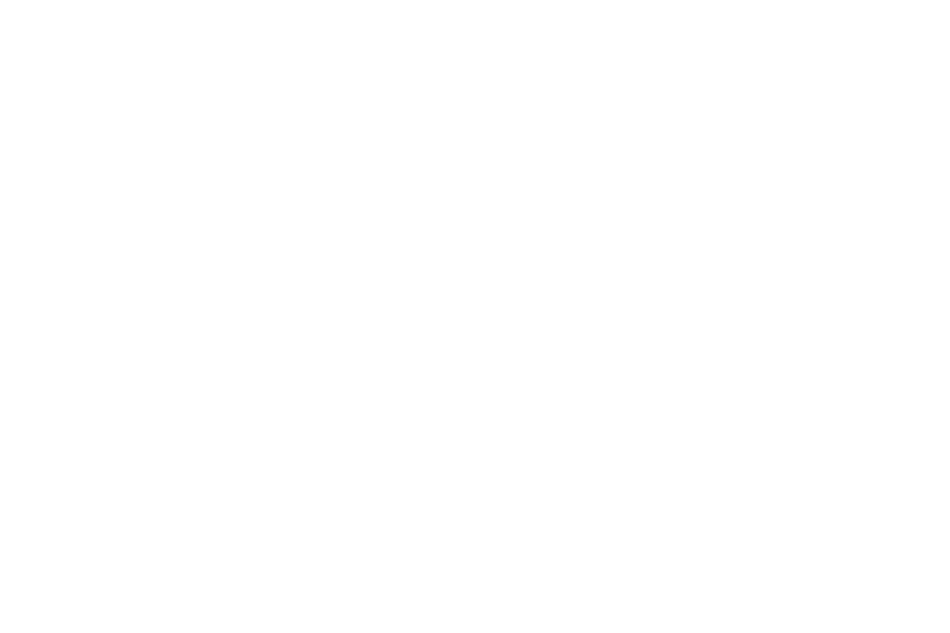

<IPython.core.display.Javascript object>


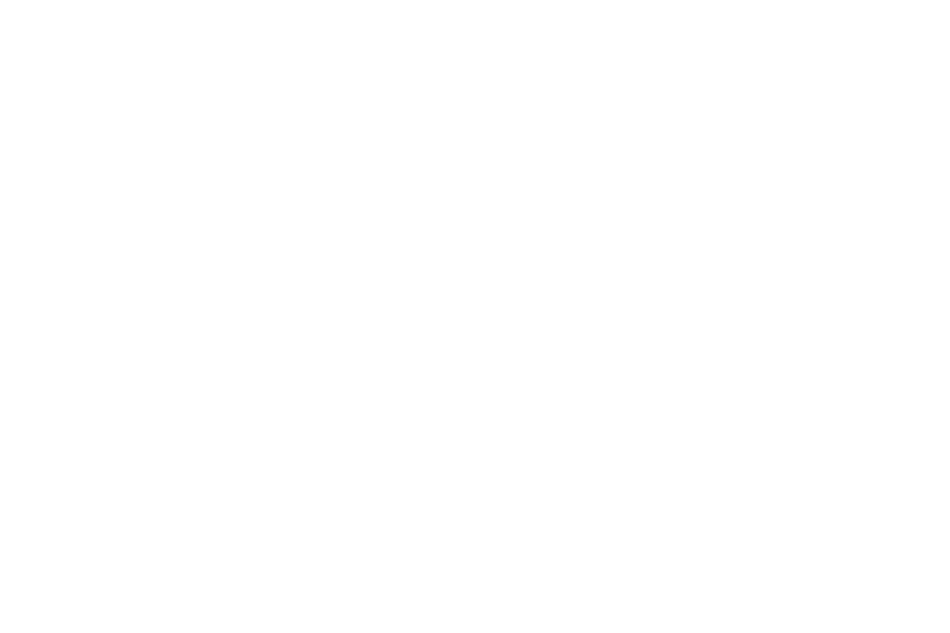

In [146]:
%matplotlib notebook
plt.plot(data_rms[5][5])
plt.grid()
plt.show()

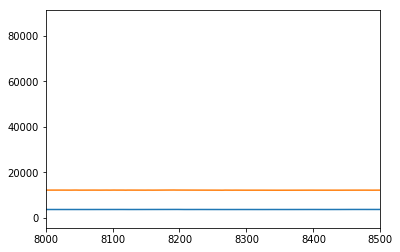

In [147]:
%matplotlib inline
plt.plot(offdata[0])
plt.plot(hotdata[0])
plt.xlim(8000,8500)
plt.show()

(-1, 1)

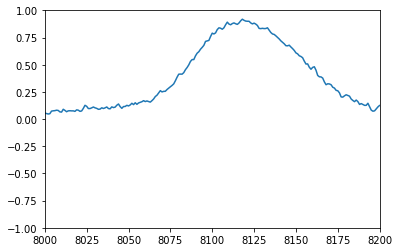

In [148]:
plt.plot(ondata[0][1][1])
plt.xlim(8000,8200)
plt.ylim(-1,1)

In [149]:
!pwd

/home/amigos/git/analy_n2data/notebook


(-2, 2)

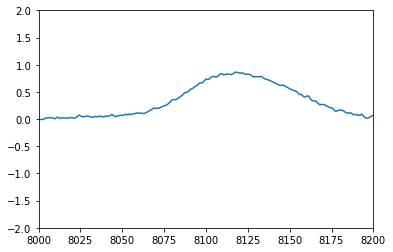

In [150]:
plt.plot(data_rms[0][0])
plt.xlim(8000,8200)
plt.ylim(-2,2)

()


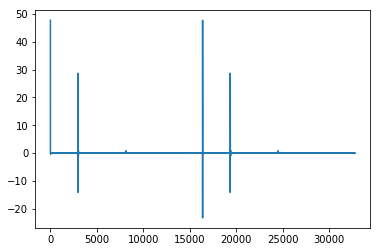

In [151]:
print(numpy.shape(data_on))
plt.plot(data_on[180])